### Run in collab
<a href="https://colab.research.google.com/github/racousin/data_science_practice/blob/master/website/public/modules/module13/exercise/module13_exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install swig==4.2.1
!pip install gymnasium==0.29.1

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque


# module13_exercise2 : ML - Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a>

### Objective
Get at list an agent running on ML-Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a> with mean reward upper than 0.35 (ie 35%)


You should submit an agent file named `agent.py` with a class `Agent` that includes at least the following attributes:

In [ ]:
class Agent:
    def __init__(self, env):
        self.env = env

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        action = self.env.action_space.sample() # your logic here
        return action

### Description

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world [7,7].

Holes in the ice are distributed in set locations.

The player makes moves until they reach the goal or fall in a hole.

Each run will consist of 10 attempts to cross the ice. The reward will be the total amount accumulated during those trips. For example, if your agent reaches the goal 3 times out of 10, its reward will be 3.

The environment is based on :

In [ ]:
env = gym.make('FrozenLake-v1', map_name="8x8")

In [ ]:
def run_experiment_episode_train(env, agent, nb_episode, is_train=True,success_threshold=0.4,window_size=100):
    rewards = np.zeros(nb_episode)
    epsilons=[]
    success_buffer = deque(maxlen=window_size)
    for i in tqdm(range(nb_episode)):
        state = env.reset()[0]
        terminated, truncated = False, False
        rews = []
        while not (terminated or truncated):
            action = agent.choose_action(state)
            current_state = state
            state, reward, terminated, truncated, info = env.step(action)
            if is_train:
                agent.train(current_state, action, reward, state, terminated or truncated)
            rews.append(reward)
        rewards[i] = episode_reward = sum(rews)
        epsilons.append(agent.epsilon)
        success_buffer.append(1 if episode_reward > 0 else 0)
        success_rate = np.mean(success_buffer)
        if success_rate > success_threshold and i > window_size:
          print(f"Training stopped at episode {i} (Success Rate: {success_rate:.2f})")
          break
        # print(f'Episode: {i} - Cumulative Reward: {rewards[i]}')
    return rewards,epsilons

In [ ]:
def get_epislon_greedy_action_from_q(Q_s,epsilon): # Q_s correspond à la ligne d'indice s (on est dans l'état s)
    if np.random.rand() > epsilon:
        return np.argmax(Q_s)
    else:
        return np.random.choice(len(Q_s))

In [ ]:
class Agent():
    def __init__(self, env, gamma = .99, epsilon = 0.2, alpha = .1,min_epsilon=0.01,epsilon_decay=0.995):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.q = np.ones((env.observation_space.n, env.action_space.n))

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        action = get_epislon_greedy_action_from_q(self.q[observation], self.epsilon)
        return action

    def qsa_update(self, observation, action, reward, next_observation, done):
        state = int(observation)
        next_state = int(next_observation)
        if done:
          target = reward
          self.epsilon_decay_exponential()
        else:
          target = reward + self.gamma*np.max(self.q[next_observation])
        td_error = target - self.q[observation,action]
        self.q[observation, action] += self.alpha*td_error

    def epsilon_decay_exponential(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, current_observation, action, reward, next_observation, done):
        self.qsa_update(current_observation, action, reward, next_observation, done)

 55%|█████▍    | 2731/5000 [00:06<00:05, 431.99it/s]


Training stopped at episode 2731 (Success Rate: 0.41)


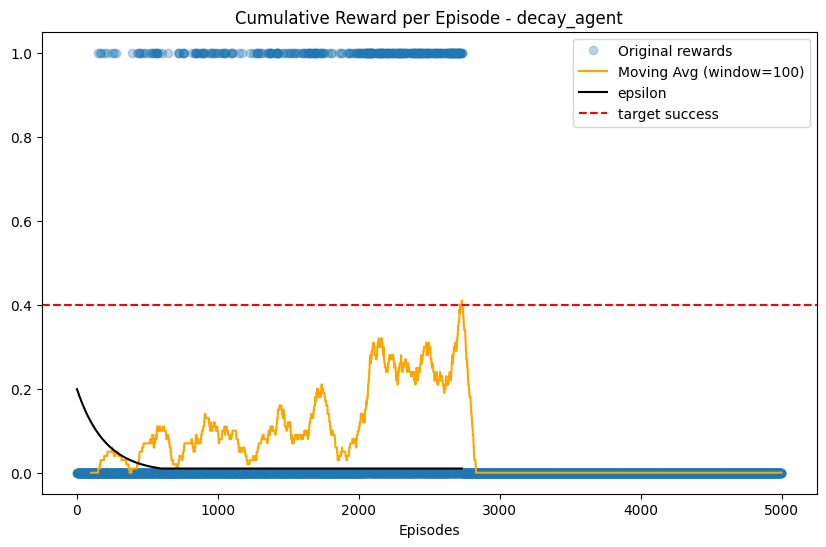

In [ ]:
my_agent = Agent(env)
rewards_decay_agent,epsilons = run_experiment_episode_train(env, my_agent, 5000)

# Compute the moving average with a window size of 100
window_size = 100
moving_avg_decay = np.convolve(rewards_decay_agent, np.ones(window_size) / window_size, mode='valid')

# Plot with subplots
plt.figure(figsize=(10, 6))

plt.plot(rewards_decay_agent, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_decay_agent)), moving_avg_decay, label=f'Moving Avg (window={window_size})', color='orange')
plt.plot(epsilons,alpha=1,color='black',label='epsilon')
plt.axhline(y=0.4, color='red', linestyle='--', label='target success')
plt.title('Cumulative Reward per Episode - decay_agent')
plt.xlabel('Episodes')
plt.legend(loc='best')

plt.show()


## Save the best policy

In [ ]:
np.save("q_table.npy", my_agent.q)

### Before submit
Test that your agent has the right attributes

In [ ]:
env = gym.make('FrozenLake-v1', map_name="8x8")
agent = Agent(env)

observation, _ = env.reset()
reward, terminated, truncated, info = None, False, False, None
rewards = []
while not (terminated or truncated):
    action = agent.choose_action(observation, reward=reward, terminated=terminated, truncated=truncated, info=info)
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
print(f'Cumulative Reward: {sum(rewards)}')

Cumulative Reward: 0.0
